### Image Classification Modelling on Trash Images

With the data having been nicely organized and processed, that means the data is ready for model building. In this stage, a deep learning classifier has to readjust itself each time images are captured to the input layer, then with forward and backward passes, the model's weights are constantly updated. Under the chain rule, each time the loss function yields the performance output, the optimizer (commonly stochastic gradient descent) takes account of the difference between ground truths and predictions that the model generates and the find the way to update weight coefficients that may bring the function closer to the minimum objective under the specified criteria. 

Our main purpose for this notebook is to establish a point where the deep learning obtains the capacity of recognizing distinctive patterns of the provided images, in this case a collection of trashes. To achieve that, a pre-trained model ResNet18 will be included and the model development will be conducted in PyTorch. Originally developed by Facebook (now Meta), PyTorch has long since earned highly reputations for solid basis of deep learning implementation in academics and industries. With rich and vast amount of libraries and modules, anyone seeking for adding strong predictive modellings for either empowering research or enhancing products with minimum barrier to thanks to dynamic computational graphs and mostly the "Pythonic" adoption on its development.

We go through detailed step-by-step of how the entire process is conducted.

In [1]:
# Import PyTorch Framework Libraries
import torch
from torch.utils.data import Dataset

# Import torchvision
import torchvision
from torchvision import transforms
from PIL import Image

In [2]:
## Importing External libraries
import numpy as np

# Import matplotlib for visualization
import matplotlib.pyplot as plt

In [3]:
# Importing built-in Python Libraries
import os
import sys
from pathlib import Path
import shutil
import glob

In [4]:
# Verify that the PyTorch can gain an access to CUDA device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cuda device


In [5]:
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.3.0+cu118
torchvision version: 0.18.0+cu118


Add a parent directory to the environment variable `PARENT_DIR` so that every data needs to be called in can easily be loaded from there. 

In [6]:
PARENT_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
PARENT_DIR

'd:\\github_repos\\mlzoomcamp\\image_classification_trash'

## Image and Data Preparation

As we noticed, the images and labels were originally provided in a large dictionary from HuggingFace hub, and it took 4-6 minutes to load a whole data. That's a reason behind resizing and downloading them in separate folders. Now, images and labels are available in three sets along with folder classes, turning them into torch Dataset objects could not be much easier as previously done before. 

In [8]:
from torchvision.datasets import ImageFolder

In [23]:
train_Dataset = ImageFolder(
                    os.path.join(PARENT_DIR, 'data', 'processed', 'trash_images_train_resized'), 
                    transform=transforms.ToTensor(),
                    target_transform=None)


val_Dataset = ImageFolder(
                    os.path.join(PARENT_DIR, 'data', 'processed', 'trash_images_val_resized'),
                    transform=transforms.ToTensor(),
                    target_transform=None)


test_Dataset = ImageFolder(
                    os.path.join(PARENT_DIR, 'data', 'processed', 'trash_images_test_resized'),
                    transform=transforms.ToTensor(),
                    target_transform=None)

### Input and Output shape

Let's view what the first image looks like, in both shape and data type.

In [10]:
# What's the shape of the image?
image, label = train_Dataset[0]
print(f'Image shape of the first image is {image.shape}')
print(f'Image format is {type(image)}')

Image shape of the first image is torch.Size([3, 512, 384])
Image format is <class 'torch.Tensor'>


In [11]:
print(f'Label of the first image is {label}')
print(f'Label format is {type(label)}')

Label of the first image is 0
Label format is <class 'int'>


A good start for us. Both image and label are already in torch format. Checking on the dimension (shape) of the image and its order, it comes in RGB color as denoted in the first value of `[3, 512, 384]`. Meanwhile, the height and width is 512 and 384 pixel, respectively.

Try to verify if torch Dataset format of the train dataset is confirmed.

In [12]:
# Verify if train_Dataset is a Dataset object
assert isinstance(train_Dataset, torch.utils.data.Dataset)

Next, we see what are classes attached to `train_Dataset`.

In [24]:
# View classes
class_names = train_Dataset.classes
class_names

['cardboard', 'glass', 'metal', 'papers', 'plastics', 'trash']

In [25]:
print(val_Dataset.classes)
print(test_Dataset.classes)

['cardboard', 'glass', 'metal', 'papers', 'plastics', 'trash']
['cardboard', 'glass', 'metal', 'papers', 'plastics', 'trash']


In [26]:
# Create a dictionary mapping of clasees for labelling
class_map = dict(zip(list(range(0, len(class_names))), class_names))
class_map

{0: 'cardboard',
 1: 'glass',
 2: 'metal',
 3: 'papers',
 4: 'plastics',
 5: 'trash'}

Knowing that six different classes populated `train_Dataset`, it is taken the case as multiclass classification. As such, we will construct a model with its output layer specified to learn and predict those classes, leaving categorical cross entropy as a suitable choice for measuring performance.

#### Visualization

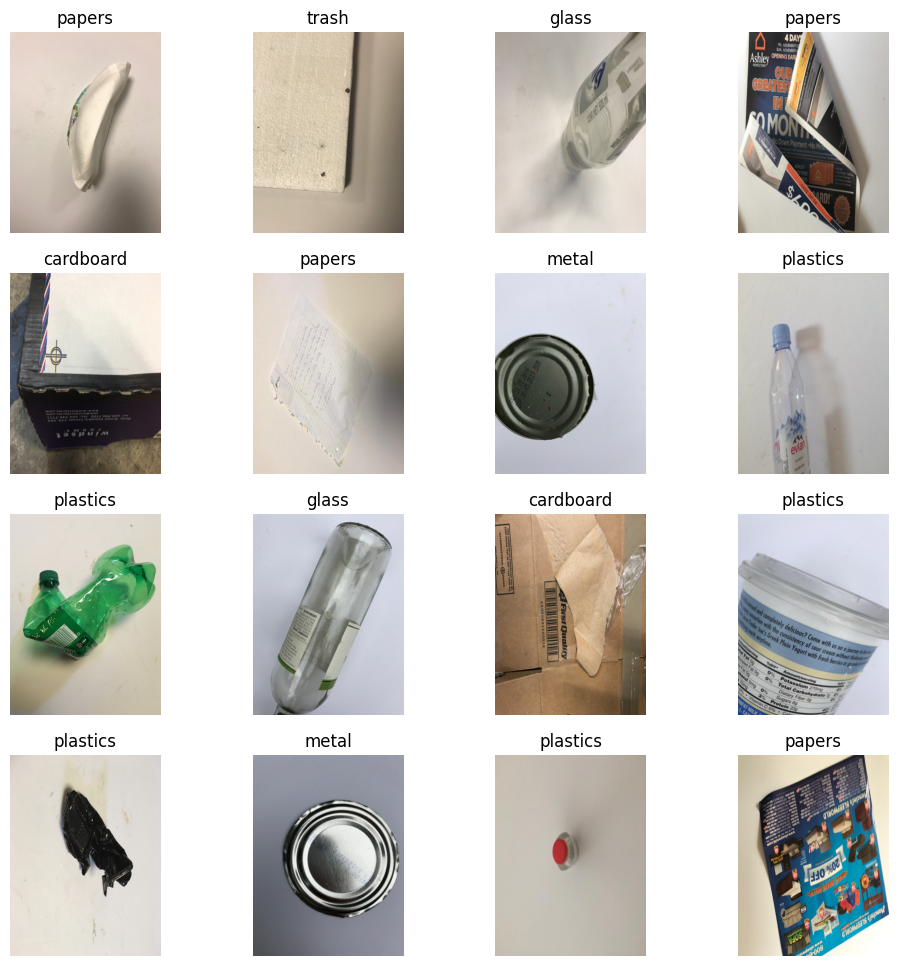

In [17]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(12, 12))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_Dataset), size=[1]).item()
    img, label = train_Dataset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze().permute(1, 2, 0))
    plt.title(class_names[label])
    plt.axis(False);

#### Transformation

To add variations of images per each set, we can apply `transforms` function to put together a few of image modification steps. Additionally, we also resize images to a smaller scale that ResNet18 can accept.

In [27]:
# Transformations for training set
train_transformer = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.RandomVerticalFlip(p=0.5),
                                        transforms.Resize((224, 224)),
                                        transforms.ToTensor()])

val_transformer = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.RandomVerticalFlip(p=0.5),
                                        transforms.Resize((224, 224)),
                                        transforms.ToTensor()])

test_transformer = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.RandomVerticalFlip(p=0.5),
                                        transforms.Resize((224, 224)),
                                        transforms.ToTensor()])

In [28]:
train_Dataset.transform = train_transformer
val_Dataset.transform = val_transformer
test_Dataset.transform = test_transformer

In [29]:
# What's the shape of the image after passing through transformation steps?
image, label = train_Dataset[0]
print(f'Image shape of the first image is {image.shape}')
print(f'Image format is {type(image)}')

Image shape of the first image is torch.Size([3, 224, 224])
Image format is <class 'torch.Tensor'>


### DataLoader

`DataLoader` turn a large dataset into an iterable object with smaller chunks. Unless the computing resource is near infinite, we can hardly imagine deep Learning capable of updating parameters and weights a whole data all at once. It's much feasible to break data into chunks (many called **batches** or **mini batches**) and let gradient descent performs more. A golden standard for `batch_size`, 32 is a good number to begin for many problems. 

In [30]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_Dataset, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

val_dataloader = DataLoader(val_Dataset,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

test_dataloader = DataLoader(test_Dataset,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

In [31]:
# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, val_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of validation dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001E073239BD0>, <torch.utils.data.dataloader.DataLoader object at 0x000001E06CF672E0>, <torch.utils.data.dataloader.DataLoader object at 0x000001E06CF67E80>)
Length of train dataloader: 110 batches of 32
Length of validation dataloader: 34 batches of 32
Length of test dataloader: 15 batches of 32


In [32]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

Image size: torch.Size([3, 224, 224])
Label: 4, label size: torch.Size([])


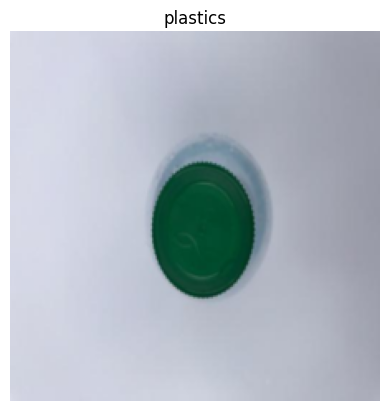

In [33]:
# Show a sample
torch.manual_seed(42)

random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze().permute(1, 2, 0))
plt.title(class_names[label])
plt.axis("Off");

print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## Transfer Learning: ResNet18

A prexisting model will be used; `ResNet18` is one of the available preset models, having already been pretrained on a much larger dataset, thus we can potentially benefit from these pretrained weight for our classification problem using the trash dataset.

Before we dive in the practical sides of transfer learning, here explained a few thoughts. As we may notice, employing the newly designed deep learning to run through the data has to take long minutes or even hours to let its weights and parameters updated to reach the desired convergence. Also, designing deeper neural networks makes training more difficult since its parameter grows each time a layer is added to the model. It is commonly associated with a large number of epochs that have to be passed since it intially has no prior domain knowledge from data. Convnets model from scratch also have to consume a vast amount of data before eventually reaching the generalization point.

That's where transfer learning comes in to mitigate these issues. In the past few years, researchers and engineers in AI field came with a few ideas of constantly feeding mpdels with large banks of images, most commonly MNIST, ImageNet, CIFAR. As such, deep learning models are now well-equipped with weights that carry "knowledge" of features gained from extensive data. The convolutional base refers to the previously trained networks to be placed by a new classifier on top. When ones try to implement these pre-trained models to learn from unseen data from other use cases, a thing to do is modify a densely classifier layer before attaching this to the last convolutional base. 

An advice is provided in some cases, that is layer freezing. It means freezing a base layer or more to keep their weights from being update during training, while also giving more chance for the classifier layer to readjust itself to the representation of data.

Let's put through transfer learning into practice. This time, `ResNet18` acts as the convolutional base to extract distinct features of six types of trash and train a new classifier based on ResNet outputs. We keep all of convolutional bases unfrozen.

In [34]:
from torchvision import models
from torch import nn
from torch import optim

# We call forth ResNet18 weight that has been previously trained on ImageNet 
weights = models.ResNet18_Weights.DEFAULT 

# Then a convolutional base mainly adopted from ResNet18 structure is created
pretrained_resnet18 = models.resnet18(weights=weights)

# Counting the number of input features on the original classifier layer
num_ftrs = pretrained_resnet18.fc.in_features

# We modify the classifier that suits our case, changing output features to six
pretrained_resnet18.fc = nn.Linear(num_ftrs, len(class_names))

In [35]:
from torchinfo import summary

summary(pretrained_resnet18, input_size=[32, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 6]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│

#### Loss Function and Optimizer

Loss function is applied as a criteria that the model aims to optimize the specified metric. In this case, given six different classes that the model has to specify, categorical cross-entropy works for multiclass classification; `CrossEntropyLoss` computes logloss from input logits and return class probabilities for each available class.

In [36]:
from torch import nn
from torch import optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_resnet18.parameters(), lr=1e-4)

To keep track on how long it taks the during training, we can utilize timer from `timeit`.

In [37]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Import default_timer from timeit
from timeit import default_timer as timer

### Model Tracking with Weights & Biases

To better accomodate model performance tracking, Weights & Biases offers ranges of features to help managing the development cycle of machine learning. We will put fews of general uses here. 

In [38]:
# Log in to your W&B account
import wandb as wb

wb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rizdi21. Use `wandb login --relogin` to force relogin


True

In [39]:
# # start a new wandb run to track this script
wb.init(
    # set the wandb project where this run will be logged
    project="image-classification-trash",

    # track hyperparameters and run metadata
    config={
        "epochs": 10,
        "batch_size": 32,
        "lr": 1e-4,
        }
)

In [40]:
# Copy your config 
config = wb.config

In [41]:
import math

n_steps_per_epoch = math.ceil(len(train_dataloader.dataset) / config.batch_size)
n_steps_per_epoch

110

For the concise training, we put together losses and accuracy of model trained on training set under a function. 

In [42]:
def log_image_table(images, predicted, labels):
    "Log a wandb.Table with (img, pred, target, scores)"
    # 🐝 Create a wb Table to log images, labels and predictions to
    table = wb.Table(columns=["image", "pred", "target"])
    for img, pred, targ in zip(images.to("cpu"), predicted.to("cpu"), labels.to("cpu")):
        table.add_data(wb.Image(img[0]), pred, targ)
    wb.log({"predictions_table":table}, commit=False)

In [43]:
def train(model, num_epochs, train_dl, valid_dl):
    """
    Begin steps of training deep learning on the given DataLoader.
    The entire information of loss and accuracy on training and validation sets are recorded in Weights & Biases. 

    Args:
        - model: a Deep learning model to be updated on weights
        - num_epochs: int
        - train_dataloader: train_dataloader
        - val_dataloader: val_dataloader

    Returns:
        - loss_hist_train: a list of loss values of training set
        - loss_hist_valid: a list of loss values of validation set
        - accuracy_hist_train: a list of accuracy values of training set
        - accuracy_hist_valid: a list of accuracy values of validation set

    """
    train_time_start_on_gpu = timer()
    
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    example_ct, step_ct = 0, 0

    model.to(device)
    for epoch in tqdm(range(num_epochs)):
        model.train()
        for step, (x_batch, y_batch) in enumerate(train_dataloader):
            # Send data to GPU
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            # 1. Forward pass
            pred = model(x_batch)

            # 2. Calculate loss
            loss = loss_fn(pred, y_batch)

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

            # 3. Optimizer zero grad
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        train_metrics = {"train_loss": loss_hist_train[epoch], 
                         "train_accuracy": accuracy_hist_train[epoch],
                         "epoch": (step + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch, 
                         "example_ct": example_ct}
            
        if step + 1 < n_steps_per_epoch:
            # 🐝 Log train metrics to wandb 
            wb.log(train_metrics)
            
        step_ct += 1
        
        model.eval()
        with torch.no_grad():
            for step, (x_batch, y_batch) in enumerate(val_dataloader):
                # Send data to GPU
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                pred = model(x_batch)
                
                loss = loss_fn(pred, y_batch)

                # Accumulate the loss and accuracy values per batch
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

                # Log one batch of images to the dashboard, always same batch_idx.
                log_image_table(x_batch, torch.argmax(pred, dim=1), y_batch)

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        val_metrics = {"val_loss": loss_hist_valid[epoch], 
                    "val_accuracy": accuracy_hist_valid[epoch]}
                
        wb.log({**train_metrics, **val_metrics})

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')

    train_time_end_on_gpu = timer()
    periods = train_time_end_on_gpu - train_time_start_on_gpu
    print(f"Train time on GPU: {periods:.4f} seconds")
    
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid


In [44]:
hist = train(pretrained_resnet18, config.epochs, train_dataloader, val_dataloader)

  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\rizdi\.virtualenvs\image_classification_trash-wqV3ZTGv\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
c:\Users\rizdi\.virtualenvs\image_classification_trash-wqV3ZTGv\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1 accuracy: 0.7983 val_accuracy: 0.9161
Epoch 2 accuracy: 0.9348 val_accuracy: 0.9199
Epoch 3 accuracy: 0.9620 val_accuracy: 0.9416
Epoch 4 accuracy: 0.9737 val_accuracy: 0.9434
Epoch 5 accuracy: 0.9817 val_accuracy: 0.9453
Epoch 6 accuracy: 0.9857 val_accuracy: 0.9632
Epoch 7 accuracy: 0.9914 val_accuracy: 0.9453
Epoch 8 accuracy: 0.9940 val_accuracy: 0.9680
Epoch 9 accuracy: 0.9920 val_accuracy: 0.9397
Epoch 10 accuracy: 0.9797 val_accuracy: 0.9482
Train time on GPU: 1723.6153 seconds


In [45]:
wb.finish()

epoch,▁▂▃▃▄▅▆▆▇█
example_ct,▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▆▇▇█████▇
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▂▄▅▅▇▅█▄▅
val_loss,█▆▄▄▄▁▄▁▅▄
epoch,10.0
example_ct,0
train_accuracy,0.97969
train_loss,0.05812
val_accuracy,0.94816


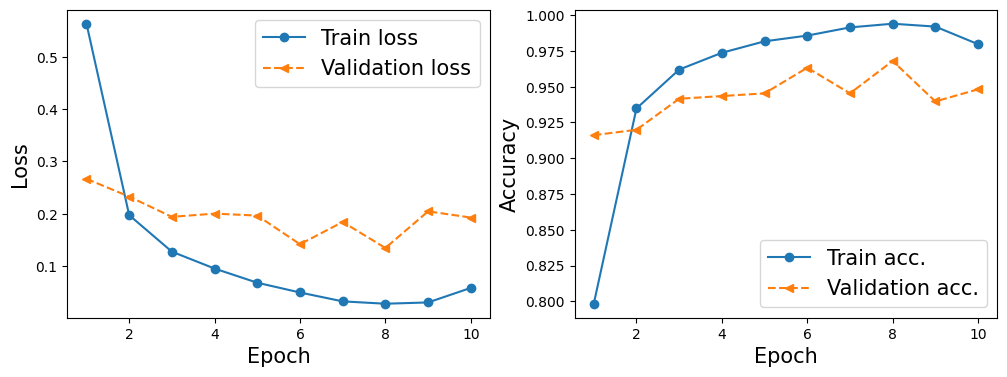

In [46]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_13.png')
plt.show()

We can safely know that ResNet18 manages to achieve remarkable performance in short epochs. We will switch the model priority from training state to inference state to see how much the model is able to predict correctly on test sets.

### Evaluation on Testing set

In [47]:
# Move values to device
torch.manual_seed(42)
def test_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn, 
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}



In [48]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [49]:
# Calculate model 1 results with device-agnostic code 
model_1_results = test_model(model=pretrained_resnet18, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
    device=device
)
model_1_results

{'model_name': 'ResNet',
 'model_loss': 0.20879603922367096,
 'model_acc': 92.62820512820512}

Now, let's try to predict some test samples with updated weight on ResNet.

In [50]:
import random

# Randomly choose 16 images and labels from test_Dataset
test_random_sample = random.sample(list(test_Dataset), k=16)

In [51]:
# View the first test sample shape and label
print(f"Test sample image shape: {test_random_sample[0][0].shape}")
print(f"Test sample label: {test_random_sample[0][1]} ({class_names[int(test_random_sample[0][1])]})")

Test sample image shape: torch.Size([3, 224, 224])
Test sample label: 4 (plastics)


In [52]:
pred_probs = []

# Set the model to eval mode
pretrained_resnet18.eval()

# activate inference mode to begin comparison of the model's inference against chosen sample data
with torch.inference_mode():
    for image in test_random_sample:
        # Prepare sample
        sample = torch.unsqueeze(image[0], dim=0).to(device) # Add an extra dimension and send sample to device

        # Forward pass (model outputs raw logit)
        pred_logit = pretrained_resnet18(sample)

        # Get prediction probability (logit -> prediction probability)
        pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

        # Get pred_prob off GPU for further calculations
        pred_probs.append(pred_prob.cpu())

In [53]:
torch.stack(pred_probs)

tensor([[1.8640e-05, 8.5373e-06, 1.7374e-06, 6.7364e-06, 9.9996e-01, 6.5842e-06],
        [8.6453e-04, 9.7089e-01, 7.8233e-05, 4.6495e-06, 2.8137e-02, 2.2325e-05],
        [1.0526e-05, 1.9862e-04, 9.9874e-01, 3.1420e-05, 1.0115e-03, 1.1407e-05],
        [3.0208e-03, 2.8192e-02, 3.9232e-02, 5.2788e-04, 9.2866e-01, 3.6343e-04],
        [1.0000e+00, 8.3292e-08, 1.1847e-07, 1.8379e-09, 2.1292e-09, 2.0441e-08],
        [8.3555e-05, 1.0917e-06, 6.6602e-07, 9.9991e-01, 7.3023e-06, 1.3311e-06],
        [9.9377e-01, 7.8922e-04, 4.8668e-03, 6.8626e-05, 4.3917e-04, 6.3851e-05],
        [2.8949e-05, 9.9818e-01, 1.9692e-05, 2.1399e-06, 1.7639e-03, 2.2770e-06],
        [2.0718e-06, 9.9999e-01, 3.3716e-07, 6.9384e-08, 8.6136e-06, 2.7272e-08],
        [2.3209e-06, 5.8507e-03, 1.1895e-06, 3.7745e-06, 9.9397e-01, 1.7286e-04],
        [2.7882e-04, 2.1791e-02, 9.7769e-01, 2.2538e-04, 5.4294e-06, 9.4468e-06],
        [6.6165e-05, 4.1370e-08, 1.9756e-07, 9.9993e-01, 3.3819e-07, 3.7937e-08],
        [2.6788e

In [54]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = torch.stack(pred_probs).argmax(dim=1)
pred_classes

tensor([4, 1, 2, 4, 0, 3, 0, 1, 1, 4, 2, 3, 4, 4, 3, 2])

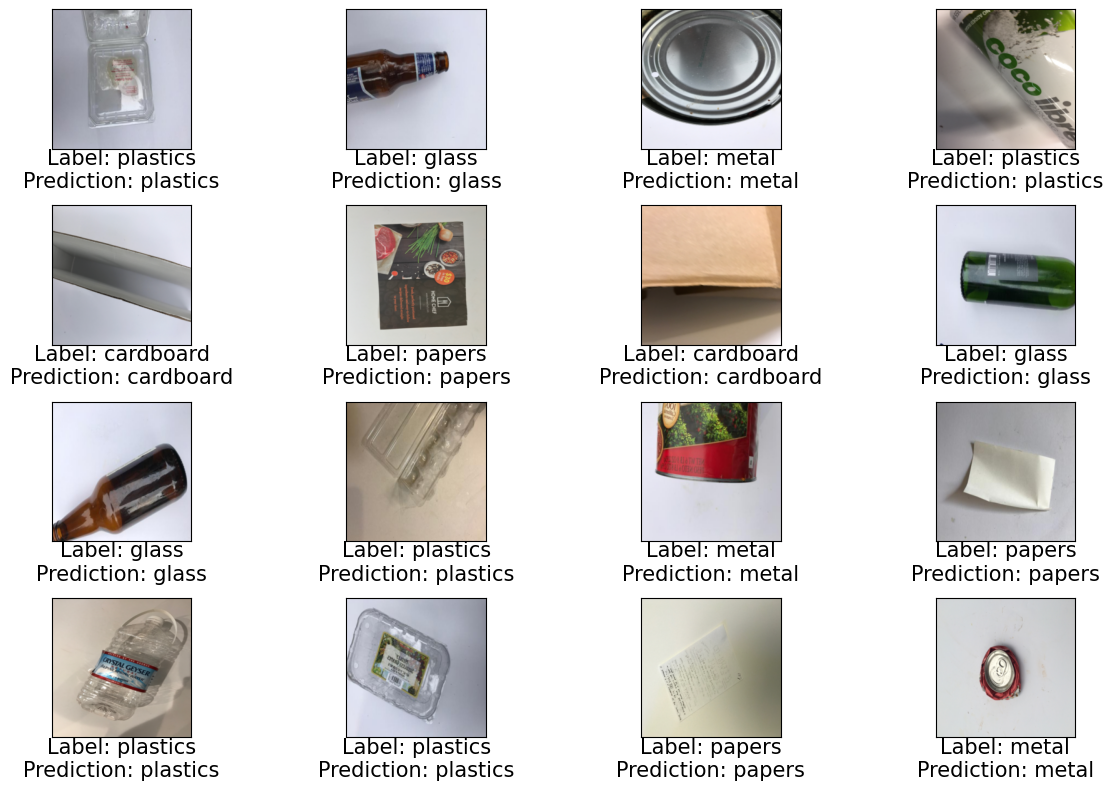

In [55]:
fig = plt.figure(figsize=(12, 8))

for i in range(len(test_random_sample)):
    ax = fig.add_subplot(4, 4, i + 1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(test_random_sample[i][0].squeeze().permute(1, 2, 0))
    ax.text(0.5, -0.15, f'Label: {class_names[test_random_sample[i][1]]}\nPrediction: {class_names[pred_classes[i]]}', 
            size=15, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

### Confusion Matrix

In [56]:
# Make predictions with trained model
y_preds = []

pretrained_resnet18.eval()
with torch.inference_mode():
    correct = 0
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
        # Send data and targets to target device
        X, y = X.to(device), y.to(device)
        # Do the forward pass
        y_logit = pretrained_resnet18(X)
        # Turn predictions from logits -> prediction probabilities -> predictions labels
        # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        
        # Put predictions on CPU for evaluation
        y_preds.append(y_pred.cpu())
        
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/15 [00:00<?, ?it/s]

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Produce a list of prediction made from the model
y_pred_list = [int(x) for x in y_pred_tensor]

In [58]:
# A new empty list
all_labels = []

# Fill this list with labels from the Dataloader of test set
for inputs, labels in test_dataloader:
    all_labels.extend(labels.cpu().numpy())

In [59]:
# Put two lists altogether to compute confusion matrix
cm = confusion_matrix(all_labels, y_pred_list)

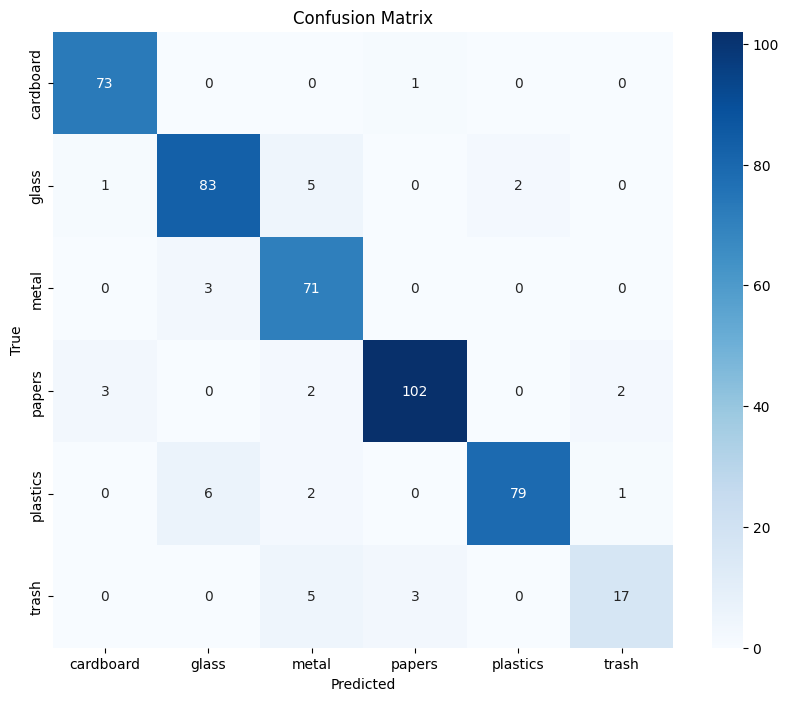

In [60]:
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_Dataset.classes, yticklabels=test_Dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Model and Data Analysis

The experiment on ResNet18 is conducted on the trash images, consisting of 3537 training images, 1061 validation images, and 456 testing images in six classes. THe modelling of ResNet18 begun by attaching a dense classification layer, which is suitable for measuring six class probabilities, to the last convolution base of ResNet18. All of base layers of the residual network remain unfrozen, much contrary to common practice that suggests freezing all pretrained layers to let the classifier making self adjustment and see how the model performs before eventually switching some convolutional base layers to unfrozen state and then resume training(Chollet mentioned this approach as fine-tuning). 

The utilization of pretrained ResNet18 for learning trash images produces a satisfying outcome. Throughout the course of training, ResNet18 consistently moves towards convergence on both sets, with a significant rise in accuracy and a drastic fall in loss on the training set in Epoch 2, before their graphs become more gradual. The model accuracies reached 98.7% and 95.4% for training and validation sets, respectively. This newly trained model then delivers near-excellent prediction results, showing 95% accuracy on the test set.  

This well-fitted model also excels in its classification capabilities for predicting trash types. Model analysis on ResNet18 using a confusion matrix shows that the model succeeds in keeping misclassified classes at a low level, with many misclassifications lying between zero and two. Attention must be paid to plastic and glass, as both are known to have transparent characteristics. ResNet mistakenly recognized six items as glass while they are actually plastics. Hence, it is advised to take these findings into an account. Several steps of data cleaning (e.g. removing product labels, taking images at appropriate settings, correcting image classes) would also support achieving better predictive modellings. 

Aside of attaining its generalization power, there are some critices to be accounted for. Firstly, images recognized as 'metal' are dominantnly populated with tin cans, showing a deviation in translating a concept interpretation of 'metal' to its physical representation. Generally, metal is known to have a wide range of products, ranging from tools and machineries used for industrial production to home appliances. Meanwhile, tin can functions solely in consumption level and it finishes in one-time use. Hence, 'tin can' are a more representable label for these objects.

A second point is the composition of images itself. The data is initially provided in a large train set downloaded from HuggingFace hub as demonstrated in another file `Download_and_Split_Data.ipynb`. Many of images are in large size, requiring some prior resizing and downloading (also populating three folders) to our local machine to make data loading to this notebook become faster. Consequently, a new set of training, validation, and test share the same variation of images, and our model has the exact knowledge needed to do the task after completing the training process. This may suggest the need for preparing images in three sets.

### Save the Model

In [55]:
# Create target directory
target_dir_path = Path(os.path.join(PARENT_DIR, "models" , "ResNet18"))
target_dir_path.mkdir(parents=True,
                    exist_ok=True)

In [56]:
model_name = "model_resnet_checkpoint_1915.pth"

# Create model save path
assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
model_save_path = target_dir_path / model_name



In [57]:
# Save the model state_dict()
print(f"[INFO] Saving model to: {model_save_path}")
torch.save(obj=pretrained_resnet18.state_dict(),
         f=model_save_path)

[INFO] Saving model to: d:\github_repos\mlzoomcamp\image_classification_trash\models\ResNet18\model_resnet_checkpoint_1915.pth
